In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
# This is a great function to learn from
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# Flights from Chicago to Hawaii lean towards being more expensive in December. Prices are generally better when you fly from Chicago to Hawaii in March.
mytrip = calc_temps('2017-03-03', '2017-03-13')
mytrip # It is a list of a tuple

[(62.0, 70.9090909090909, 82.0)]

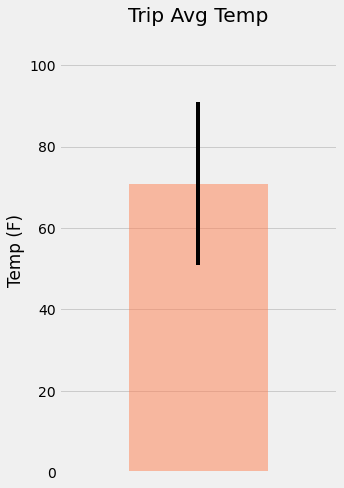

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mytrip_df = pd.DataFrame(mytrip, columns=["TMIN", "TAVG", "TMAX"])
mytrip_df

mytrip_df.plot.bar(y="TAVG", yerr=(mytrip_df["TMAX"] - mytrip_df["TMIN"]), 
                    title="Trip Avg Temp", color="coral", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.margins(.2, .2)
plt.tight_layout()
plt.savefig("Images/Trip Avg Temperature.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-03-03'
end_date = '2017-03-13'

In [13]:
# # This is a test without join
# session.query(Measurement.station, func.sum(Measurement.prcp)).\
#     filter(Measurement.date >= '2017-03-03').\
#     filter(Measurement.date <= '2017-03-13').\
#     group_by(Measurement.station).\
#     order_by(func.sum(Measurement.prcp).desc()).all()

In [14]:
sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

In [15]:
# join two tables together in filter(Measurement.station == Station.station)!

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()
results

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.11),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.4),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.92),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.82),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.25),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.14)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activestations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
# This is a great function to learn from - similar to Today in History concept
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-03-03'
end_date = '2017-03-13'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, freq='D')
trip_dates # It is a list
# Strip off the year and save a list of !strings! in the format %m-%d
trip_month_day = trip_dates.strftime('%m-%d')
trip_month_day # It is a list
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for candidateday in trip_month_day:
    normals.append(*daily_normals(candidateday)) # Go through the daily_normals() function to return (tmin, tavg, and tmax) and then append to the list normals

normals # It is a list of tuples

[(60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0)]

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df['Date'] = trip_dates # add the date column
normals_df.set_index(['Date'],inplace=True)
normals_df

,tmin,tavg,tmax
Date,,,
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0
2017-03-10,57.0,69.122807,75.0
2017-03-11,60.0,69.892857,82.0


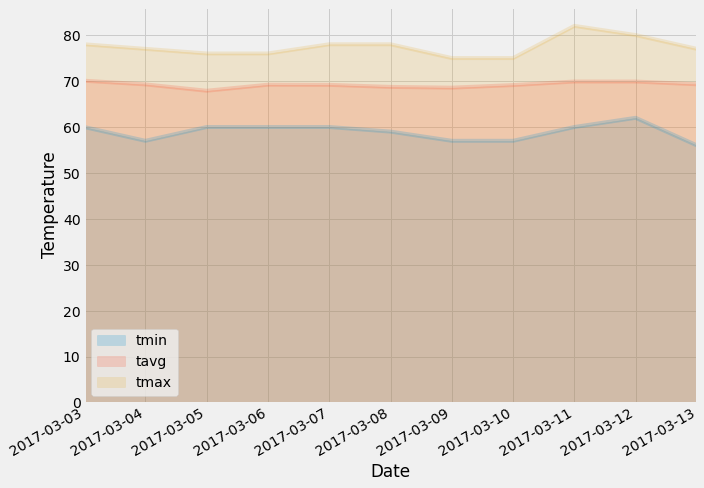

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2, figsize=(10,7))
plt.ylabel("Temperature")
plt.margins(0, 0)
plt.tight_layout()
plt.savefig("Images/Trip Daily Temperature.png")
plt.show()

## Close Session

In [21]:
session.close()